In [1]:
#import all libraries
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
files = files.upload()

Saving sorted_final.csv to sorted_final.csv


In [60]:
df = pd.read_csv("sorted_final.csv",index_col = 0)
df.head()

,Station Names,YEAR,Max Temp,Min Temp,Rainfall,Relative Humidity,Wind Speed,Cloud Coverage,Bright Sunshine,Aus_Area,Aus_Production,Amon_Area,Amon_Production,Boro_Area,Boro_Production
0,Barisal,1970,29.849167,21.335000,201.083333,21.335000,1.373333,4.080833,4.080833,NaN,NaN,NaN,NaN,NaN,NaN
1,Bhola,1970,29.835833,21.125000,172.833333,21.125000,2.446667,4.589167,4.589167,NaN,NaN,NaN,NaN,NaN,NaN
2,Bogra,1970,30.431667,20.925833,149.500000,20.925833,1.027500,3.460833,3.460833,286080.0,86400.2994,634460.0,254832.8024,30320.0,20574.9558
3,Chandpur,1970,29.203333,22.090000,131.666667,22.090000,1.090833,2.110833,2.110833,NaN,NaN,NaN,NaN,NaN,NaN
4,Chittagong,1970,29.751667,21.529167,235.666667,21.529167,2.470000,4.370833,4.370833,264775.0,110195.7620,497290.0,289460.0539,143481.0,147662.5025


# FEATURE ENGINEERING

In [ ]:
aus_features =['Station Names','YEAR','Max Temp','Min Temp','Rainfall','Relative Humidity','Wind Speed','Cloud Coverage','Bright Sunshine','Aus_Area','Aus_Production']

In [ ]:
df.drop(columns=['Unnamed: 0.1','Amon_Area', 'Amon_Production','Boro_Area','Boro_Production'],inplace = True)

In [ ]:
df.columns = aus_features

In [ ]:
df.dtypes

Station Names         object
YEAR                   int64
Max Temp             float64
Min Temp             float64
Rainfall             float64
Relative Humidity    float64
Wind Speed           float64
Cloud Coverage       float64
Bright Sunshine      float64
Aus_Area             float64
Aus_Production       float64
dtype: object

In [ ]:
x = df.drop('Aus_Production',axis =1)
y = df['Aus_Production']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 23)

# Handling String values

In [ ]:
le = LabelEncoder()
x_train['Station Names'] = le.fit_transform(x_train[['Station Names']])
x_test['Station Names'] = le.fit_transform(x_test[['Station Names']])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# VISUALIZATION

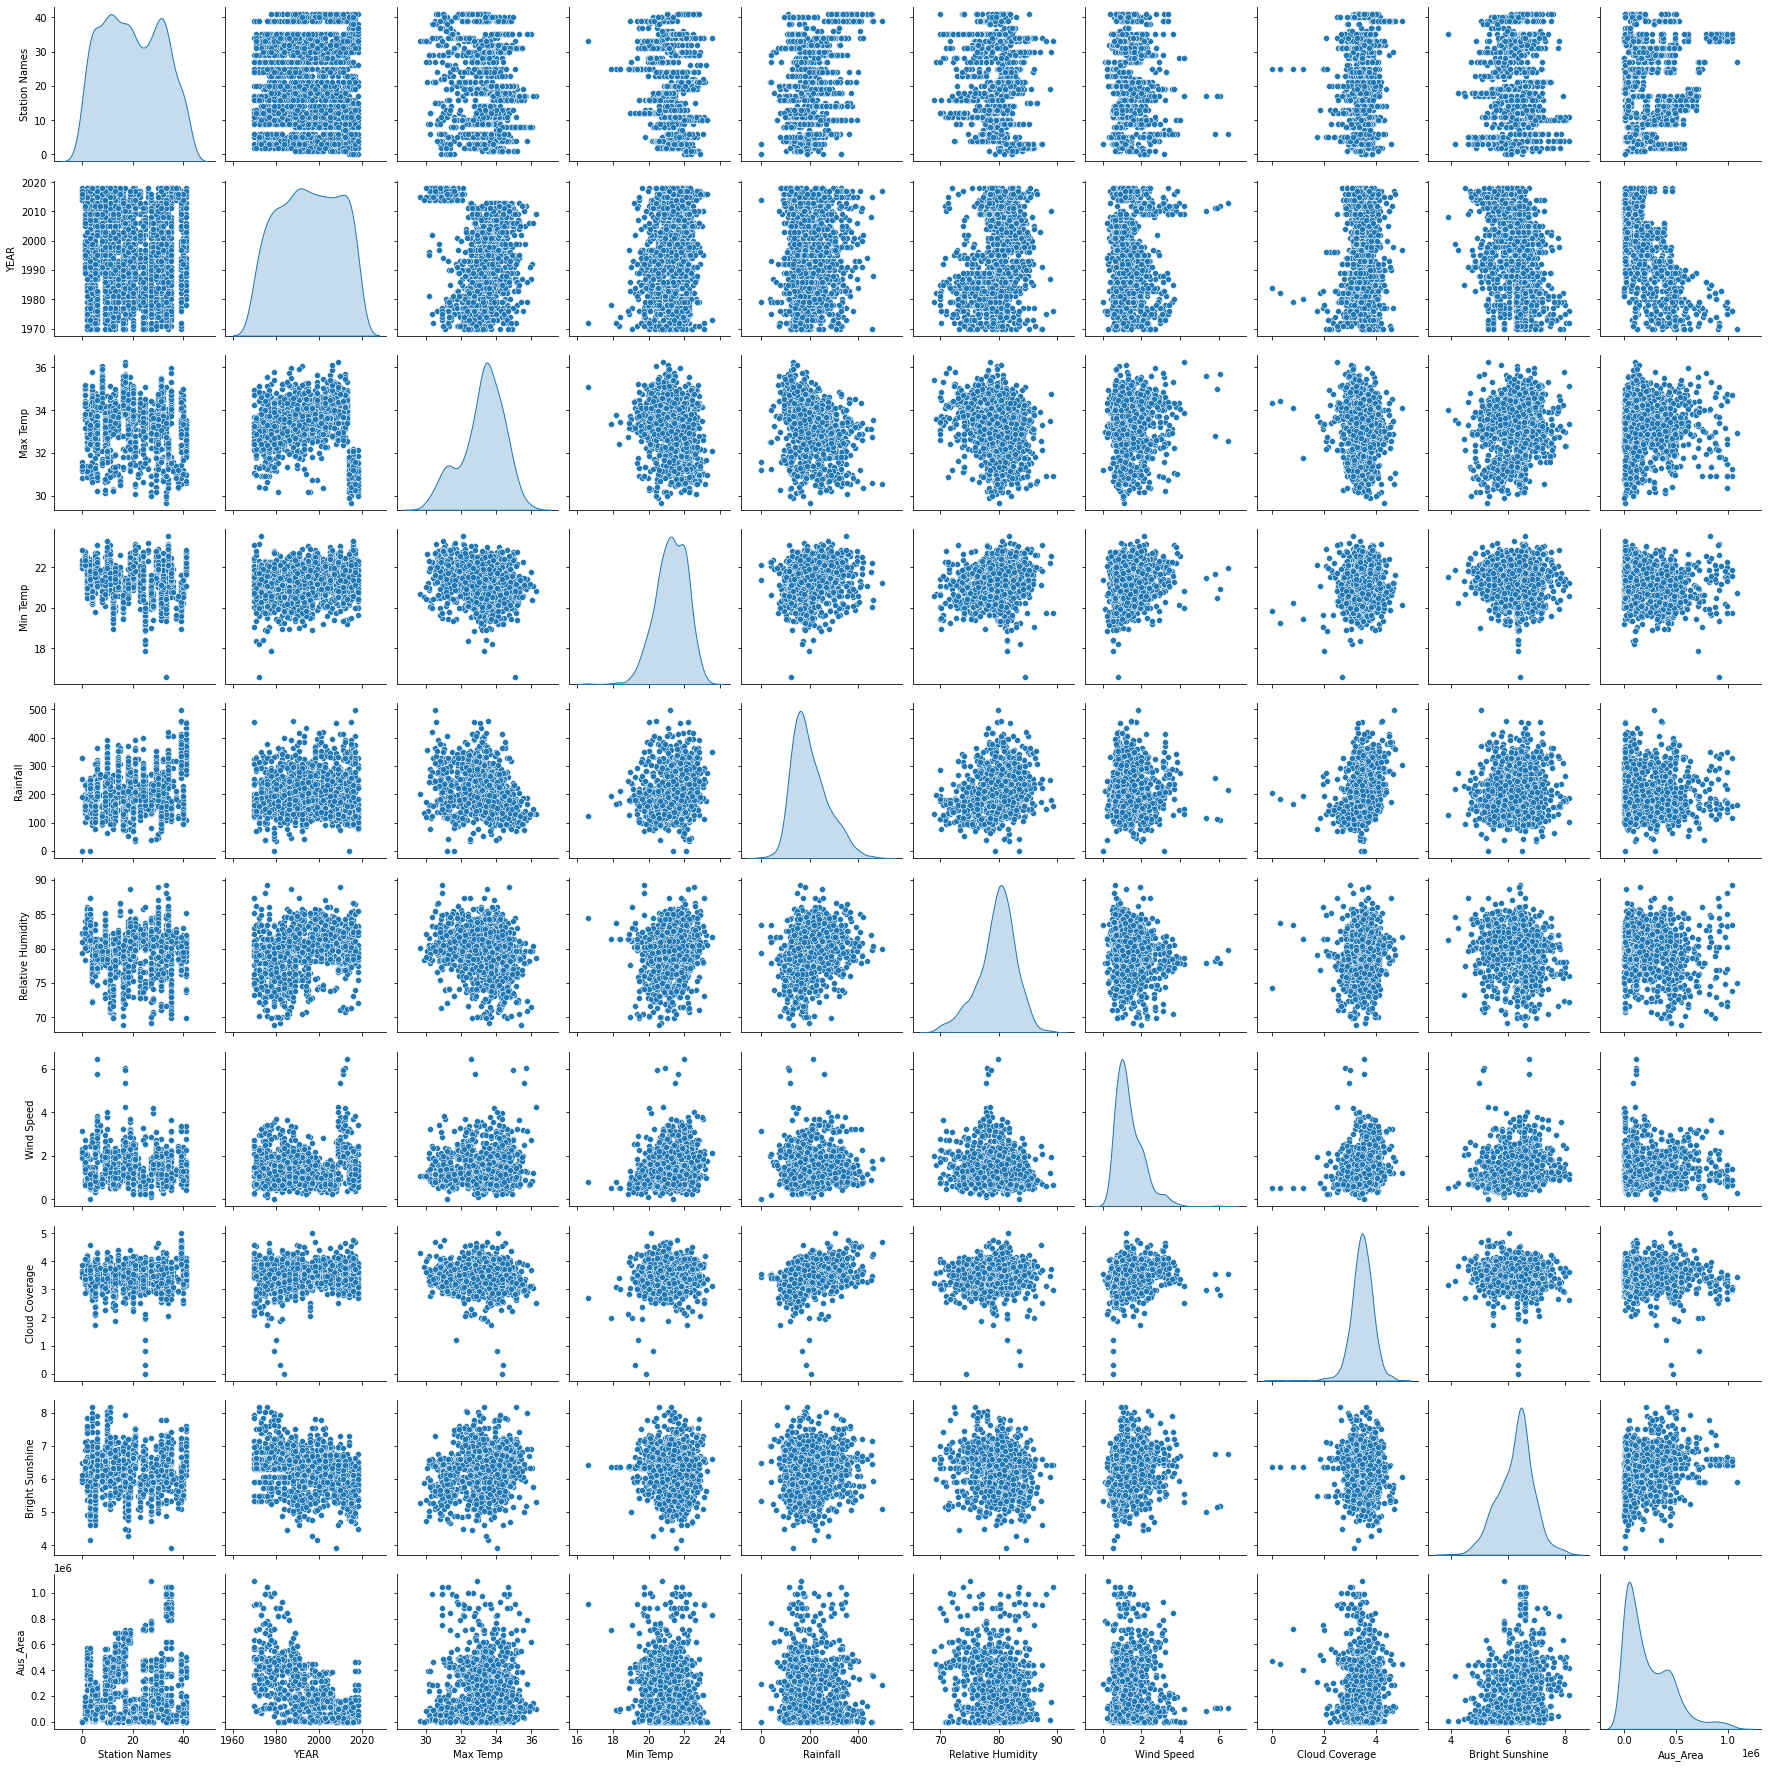

In [ ]:
sns.pairplot(x_train[['Station Names','YEAR','Max Temp','Min Temp','Rainfall','Relative Humidity','Wind Speed','Cloud Coverage','Bright Sunshine','Aus_Area']], diag_kind = "kde")

# FEATURE SCALING

In [ ]:
#scalling data
Scaler = StandardScaler()
Scaler.fit(x_train)
x_trainScaled = Scaler.transform(x_train)

In [ ]:
Scaler.fit(x_test)
x_testScaled = Scaler.transform(x_test)

# MODEL

random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
rf_model= RandomForestRegressor(n_estimators = 200,random_state=60)
rf_model.fit(x_trainScaled, y_train)

RandomForestRegressor(n_estimators=200, random_state=60)

In [ ]:
predict_with_regressor = rf_model.predict(x_testScaled)

In [ ]:
mse_regressor = mean_squared_error(y_test, predict_with_regressor)
mae_regressor = mean_absolute_error(y_test, predict_with_regressor)
print("mean squared error for Randomforest= ",mse_regressor)
print("mean absoluate error for Randomforest= ",mae_regressor)

mean squared error for Randomforest=  515656640.48432904
mean absoluate error for Randomforest=  13851.628656364106


In [ ]:
from sklearn.metrics import r2_score

In [ ]:
accuracy = r2_score(y_test,predict_with_regressor)
print(accuracy*100)

89.66776724670694


In [ ]:
features_list = list(x.columns)
features_imp = pd.Series(rf_model.feature_importances_, index = features_list).sort_values
print(features_imp)

<bound method Series.sort_values of Station Names        0.015877
YEAR                 0.037497
Max Temp             0.007133
Min Temp             0.004429
Rainfall             0.008010
Relative Humidity    0.005784
Wind Speed           0.007592
Cloud Coverage       0.006094
Bright Sunshine      0.006723
Aus_Area             0.900862
dtype: float64>


In [ ]:
predict_with_regressor = rf_model.predict(x_testScaled[:5])
print("predicted data=\n",predict_with_regressor)
print("real data=\n",y_test[:5])

predicted data=
 [ 16156.32251265  84169.44190505 102382.87160515  30090.2419863
   4829.21195703]
real data=
 779     12201.63825
1507    53009.00000
293     71794.62090
1072    18338.74478
1420     2130.00000
Name: Aus_Production, dtype: float64


Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
tree.fit(x_trainScaled, y_train)
predict_with_tree = tree.predict(x_testScaled)
mse_tree = mean_squared_error(y_test, predict_with_tree)
mae_tree = mean_absolute_error(y_test, predict_with_tree)
print("mean squared error for tree= ",mse_tree)
print("mean absoluate error for tree= ",mae_tree)

mean squared error for tree=  858340497.4542456
mean absoluate error for tree=  17236.175209663463


linear rgression

In [ ]:
from sklearn import linear_model
lr_model = linear_model.LinearRegression()
lr_model.fit(x_trainScaled, y_train)
predict_with_linear = lr_model.predict(x_testScaled)
mse_linear = mean_squared_error(y_test, predict_with_linear)
mae_linear = mean_absolute_error(y_test, predict_with_linear)
print("mean squared error for linear= ",mse_linear)
print("mean absoluate error for linear= ",mae_linear)

mean squared error for linear=  875061673.7314057
mean absoluate error for linear=  21101.285911085623


Neural network

In [61]:
def avg_temp(df):
  df['Average_temperature'] = df[['Max Temp', 'Min Temp']].mean(axis=1)
  return df

In [62]:
df = avg_temp(df)

In [63]:
df = df.interpolate(method = 'linear', limit =2)
df_new = df.fillna(method = 'bfill',limit = 2)
df_new2 = df_new.fillna(method = 'ffill',limit =2)
df_new2.isnull().sum()

Station Names          0
YEAR                   0
Max Temp               0
Min Temp               0
Rainfall               0
Relative Humidity      0
Wind Speed             0
Cloud Coverage         0
Bright Sunshine        0
Aus_Area               0
Aus_Production         0
Amon_Area              0
Amon_Production        0
Boro_Area              0
Boro_Production        0
Average_temperature    0
dtype: int64

In [64]:
aus_avg = df_new2[['Station Names','YEAR','Average_temperature','Rainfall','Relative Humidity','Wind Speed','Cloud Coverage','Bright Sunshine','Aus_Area','Aus_Production']]

In [65]:
amon_avg = df_new2[['Station Names','YEAR','Average_temperature','Rainfall','Relative Humidity','Wind Speed','Cloud Coverage','Bright Sunshine','Amon_Area','Amon_Production']]

In [66]:
boro_avg = df_new2[['Station Names','YEAR','Average_temperature','Rainfall','Relative Humidity','Wind Speed','Cloud Coverage','Bright Sunshine','Boro_Area','Boro_Production']]

In [8]:
aus_avg.dropna(axis = 0, inplace = True)
aus_avg.isnull().sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Station Names          0
YEAR                   0
Average_temperature    0
Rainfall               0
Relative Humidity      0
Wind Speed             0
Cloud Coverage         0
Bright Sunshine        0
Aus_Area               0
Aus_Production         0
dtype: int64

In [25]:
amon_avg.dropna(axis = 0, inplace = True)
amon_avg.isnull().sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Station Names          0
YEAR                   0
Average_temperature    0
Rainfall               0
Relative Humidity      0
Wind Speed             0
Cloud Coverage         0
Bright Sunshine        0
Amon_Area              0
Amon_Production        0
dtype: int64

In [26]:
boro_avg.dropna(axis = 0, inplace = True)
boro_avg.isnull().sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Station Names          0
YEAR                   0
Average_temperature    0
Rainfall               0
Relative Humidity      0
Wind Speed             0
Cloud Coverage         0
Bright Sunshine        0
Boro_Area              0
Boro_Production        0
dtype: int64

In [67]:
x = aus_avg.drop('Aus_Production',axis =1)
y = aus_avg['Aus_Production']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 23)
le = LabelEncoder()
x_train['Station Names'] = le.fit_transform(x_train[['Station Names']])
x_test['Station Names'] = le.fit_transform(x_test[['Station Names']])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [68]:
x_amon = amon_avg.drop('Amon_Production',axis =1)
y_amon = amon_avg['Amon_Production']
x_amon_train, x_amon_test, y_amon_train, y_amon_test = train_test_split(x_amon, y_amon, test_size = 0.20, random_state = 23)
le = LabelEncoder()
x_amon_train['Station Names'] = le.fit_transform(x_amon_train[['Station Names']])
x_amon_test['Station Names'] = le.fit_transform(x_amon_test[['Station Names']])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [69]:
x_boro = boro_avg.drop('Boro_Production',axis =1)
y_boro = boro_avg['Boro_Production']
x_boro_train, x_boro_test, y_boro_train, y_boro_test = train_test_split(x_boro, y_boro, test_size = 0.20, random_state = 23)
le = LabelEncoder()
x_boro_train['Station Names'] = le.fit_transform(x_boro_train[['Station Names']])
x_boro_test['Station Names'] = le.fit_transform(x_boro_test[['Station Names']])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [70]:
x_boro_test

,Station Names,YEAR,Average_temperature,Rainfall,Relative Humidity,Wind Speed,Cloud Coverage,Bright Sunshine,Boro_Area
679,32,1998,26.491667,143.916667,21.719167,0.885833,3.683333,3.683333,692373.333333
768,30,2000,24.772500,145.416667,20.085000,1.365833,3.630833,3.630833,801070.000000
182,13,1984,25.518750,212.000000,20.672500,1.234167,2.965000,2.965000,97285.000000
1072,23,1973,26.491667,206.916667,85.333333,0.541667,3.208333,6.355655,117085.000000
474,31,1992,26.018750,240.000000,22.890833,1.983333,3.205000,3.205000,545133.333333
...,...,...,...,...,...,...,...,...,...
871,31,2003,27.184220,0.000000,83.481884,1.563475,3.296920,6.533333,836416.666667
433,22,1991,27.387500,291.250000,82.583333,0.858333,3.458333,5.491667,262890.000000
52,35,1979,26.112083,91.583333,22.111667,2.139167,3.512500,3.512500,332820.000000
955,11,2006,26.854583,159.916667,22.434167,0.824167,3.755000,3.755000,597595.000000


In [71]:
Scaler = StandardScaler()
Scaler.fit(x_train)
x_trainScaled = Scaler.transform(x_train)
Scaler.fit(x_test)
x_testScaled = Scaler.transform(x_test)
x_testScaled

array([[ 1.32581792,  0.1819022 ,  0.38344737, ...,  0.40649806,
        -0.29770575,  0.64271435],
       [ 1.12970213,  0.3294032 , -1.66051827, ...,  0.278187  ,
        -0.34324926, -0.92087801],
       [-0.53728207, -0.85060484, -0.77328065, ..., -1.34912311,
        -0.92085661,  1.68633993],
       ...,
       [ 1.6199916 , -1.21935735, -0.06784994, ..., -0.01102205,
        -0.44590288,  1.00180351],
       [-0.73339786,  0.77190622,  0.81492921, ...,  0.58165285,
        -0.23553525, -0.9764152 ],
       [-1.7139768 , -0.03934931,  2.68204178, ..., -0.10267281,
         2.17688047,  0.32422447]])

In [72]:
Scaler = StandardScaler()
Scaler.fit(x_boro_train)
x_boro_trainScaled = Scaler.transform(x_boro_train)
Scaler.fit(x_boro_test)
x_boro_testScaled = Scaler.transform(x_boro_test)
x_boro_testScaled

array([[ 1.32581792,  0.1819022 ,  0.38344737, ...,  0.40649806,
        -0.29770575,  2.0948764 ],
       [ 1.12970213,  0.3294032 , -1.66051827, ...,  0.278187  ,
        -0.34324926,  2.62305795],
       [-0.53728207, -0.85060484, -0.77328065, ..., -1.34912311,
        -0.92085661, -0.79679162],
       ...,
       [ 1.6199916 , -1.21935735, -0.06784994, ..., -0.01102205,
        -0.44590288,  0.34772591],
       [-0.73339786,  0.77190622,  0.81492921, ...,  0.58165285,
        -0.23553525,  1.63432717],
       [-1.7139768 , -0.03934931,  2.68204178, ..., -0.10267281,
         2.17688047, -0.663333  ]])

In [73]:
Scaler = StandardScaler()
Scaler.fit(x_amon_train)
x_amon_trainScaled = Scaler.transform(x_amon_train)
Scaler.fit(x_amon_test)
x_amon_testScaled = Scaler.transform(x_amon_test)
x_amon_testScaled

array([[ 1.32581792,  0.1819022 ,  0.38344737, ...,  0.40649806,
        -0.29770575,  1.63240532],
       [ 1.12970213,  0.3294032 , -1.66051827, ...,  0.278187  ,
        -0.34324926,  2.39222808],
       [-0.53728207, -0.85060484, -0.77328065, ..., -1.34912311,
        -0.92085661,  0.13953353],
       ...,
       [ 1.6199916 , -1.21935735, -0.06784994, ..., -0.01102205,
        -0.44590288,  0.95430463],
       [-0.73339786,  0.77190622,  0.81492921, ...,  0.58165285,
        -0.23553525, -0.61790102],
       [-1.7139768 , -0.03934931,  2.68204178, ..., -0.10267281,
         2.17688047,  0.20407317]])

In [50]:
x_trainScaled

array([[ 0.43367928, -1.75629792, -1.02657542, ..., -0.24103941,
         2.28427353,  1.32607369],
       [-1.20120197, -0.96201501, -0.8448204 , ..., -0.74821624,
        -0.71282862, -0.05872801],
       [-1.20120197,  1.27641866, -0.35878542, ...,  0.18707182,
        -0.33228514, -0.58983193],
       ...,
       [ 0.60577204,  0.62655082, -1.21123387, ...,  0.41269802,
        -0.24048393, -0.33228024],
       [-1.02910921, -0.02331702,  0.26429169, ..., -0.83588559,
         2.26587219, -0.375907  ],
       [ 1.20809671, -0.3843547 , -0.86514444, ...,  0.81766811,
        -0.07571253,  0.89729288]])

In [74]:
model =Sequential()
model.add(Dense(128, input_dim = 9, activation = 'relu'))
model.add(Dense(64, activation ='relu'))
model.add(Dense(1, activation = 'linear'))
model.compile(loss ='mean_squared_error', optimizer ='adam', metrics=['mae'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               1280      
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9,601
Trainable params: 9,601
Non-trainable params: 0
_________________________________________________________________


In [83]:
history = model.fit(x_trainScaled, y_train, validation_split = 0.2, epochs = 200)

Epoch 1/200
32/32 [==============================] - 0s 4ms/step - loss: 67947880448.0000 - mae: 245204.7344 - val_loss: 61507297280.0000 - val_mae: 229021.2969
Epoch 2/200
32/32 [==============================] - 0s 3ms/step - loss: 50533789696.0000 - mae: 211626.9688 - val_loss: 47160311808.0000 - val_mae: 200768.8438
Epoch 3/200
32/32 [==============================] - 0s 3ms/step - loss: 40131936256.0000 - mae: 188581.7656 - val_loss: 38464225280.0000 - val_mae: 181257.5781
Epoch 4/200
32/32 [==============================] - 0s 3ms/step - loss: 33355257856.0000 - mae: 171830.8438 - val_loss: 32396488704.0000 - val_mae: 166201.7031
Epoch 5/200
32/32 [==============================] - 0s 3ms/step - loss: 28420370432.0000 - mae: 158405.7656 - val_loss: 27847331840.0000 - val_mae: 153839.6094
Epoch 6/200
32/32 [==============================] - 0s 3ms/step - loss: 24669501440.0000 - mae: 147241.7500 - val_loss: 24277776384.0000 - val_mae: 143363.2969
Epoch 7/200
32/32 [===============

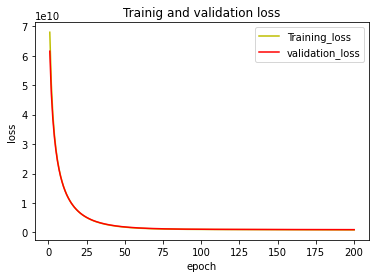

In [84]:
from matplotlib import pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch = range(1,len(loss) + 1)
plt.plot(epoch, loss, 'y', label ='Training_loss')
plt.plot(epoch, val_loss, 'r', label='validation_loss')
plt.title('Trainig and validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

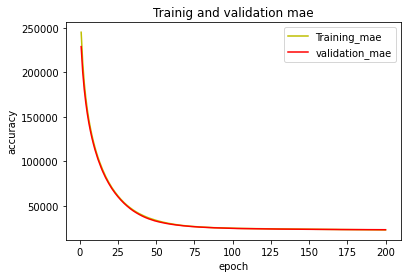

In [85]:
mae=history.history[ 'mae']
val_mae = history.history['val_mae']
plt.plot(epoch, mae, 'y', label ='Training_mae')
plt.plot(epoch, val_mae, 'r', label='validation_mae')
plt.title('Trainig and validation mae')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [18]:
#prediction
neural =model.predict(x_testScaled[:5])
print("predicted data=\n",neural)
print("real data=\n",y_test[:5])

predicted data=
 [[ 44340.723]
 [ 56021.137]
 [ 70188.32 ]
 [115952.555]
 [264252.66 ]]
real data=
 1162     35466.39758
1357     37880.00000
1531     77092.00000
652     122288.53800
166     286520.77450
Name: Aus_Production, dtype: float64


In [19]:
mse_neural, mae_neural = model.evaluate(x_testScaled,y_test)
print("mean squared error for neural naetwork= ",mse_neural)
print("mean absoluate error for neural network= ",mae_neural)

6/6 [==============================] - 0s 3ms/step - loss: 1249567360.0000 - mae: 25491.8086
mean squared error for neural naetwork=  1249567360.0
mean absoluate error for neural network=  25491.80859375


In [86]:
neural =model.predict(x_testScaled)
from sklearn.metrics import r2_score
acc = r2_score(y_test,neural)
print(acc*100)

83.84789546581052
